# Logistic and softmax regression examples

## Logistic regression
### Generating sample data

For logistic regression we'll take our input features to be two randomly generated numbers on the interval [0,1].  The target values for each example will be taken by adding the two input features, plus a small amount of Gaussian white noise, and checking if the input is greater than 1.  If it is, the label for the example is 1, if not, the label is 0.

In [15]:
import numpy as np


def create_one_batch(batch_size: int, noise_std_dev: float):
    inputs = np.random.rand(batch_size, 2)
    noise = np.random.normal(0, noise_std_dev, batch_size)
    signals = np.sum(inputs, axis=1) + noise
    targets = (signals > 1) * np.ones(batch_size)
    return inputs, targets
    
    
def generate_example_batches(batch_size: int, n_batches: int, noise_std_dev):
    for _ in range(n_batches):
        next_batch = create_one_batch(batch_size, noise_std_dev)
        yield next_batch
    

list(generate_example_batches(5, 2, noise_std_dev=0.0))

[(array([[0.1538555 , 0.3090821 ],
         [0.95078971, 0.97102455],
         [0.0774245 , 0.88545861],
         [0.967781  , 0.35631416],
         [0.71623039, 0.05198432]]), array([0., 1., 0., 1., 0.])),
 (array([[0.17050939, 0.98551037],
         [0.74250621, 0.20638811],
         [0.02758362, 0.00403964],
         [0.41644223, 0.90346775],
         [0.04990689, 0.58055681]]), array([1., 0., 0., 1., 0.]))]

### Building the model
We'll create the logistic regression model in PyTorch from the start this time, and let it handle details about updating model weights during training.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LogisticRegressor(nn.Module):
    
    def __init__(self):
        super(LogisticRegressor, self).__init__()
        self.linear_layer = nn.Linear(2, 1, bias=True)
    
    def forward(self, X):
        return torch.squeeze(self.linear_layer(torch.Tensor(X)))
    

def get_model_accuracy(model: nn.Module, X_test: np.array, y_test: np.array):
    scores = torch.sigmoid(model(X_test))
    y_pred = torch.round(scores)
    values_matched = torch.eq(torch.Tensor(y_test), y_pred)
    return torch.mean(values_matched.double())


def train_one_epoch(model: nn.Module, batches, lr: float):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.BCEWithLogitsLoss()
    for X, y in batches:
        y_pred = model(X)
        loss = loss_function(y_pred, torch.Tensor(y))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model

        
def train_one_model(lr: float, n_epochs: int, noise_std_dev: float):
    model = LogisticRegressor()
    X_test, y_test = next(generate_example_batches(batch_size=50, n_batches=1, noise_std_dev=noise_std_dev))
    initial_accuracy = get_model_accuracy(model, X_test, y_test)
    print("Accuracy before training (should be random): {0}".format(initial_accuracy))
    accuracies = [initial_accuracy]
    for epoch in range(n_epochs):
#         print("Beginning training epoch {0}".format(epoch))
        training_batches = generate_example_batches(batch_size=10, n_batches=50, noise_std_dev=noise_std_dev)
        model = train_one_epoch(model, training_batches, lr=lr)
        accuracy = get_model_accuracy(model=model, X_test=X_test, y_test=y_test)
#         print("Accuracy after training epoch {0}: {1}".format(epoch, accuracy))
        accuracies.append(accuracy)
    print("Final accuracy: {0}".format(accuracies[-1]))
    return accuracies    

Accuracy before training (should be random): 0.4
Final accuracy: 0.96
Accuracy before training (should be random): 0.48
Final accuracy: 0.84
Accuracy before training (should be random): 0.56
Final accuracy: 0.76


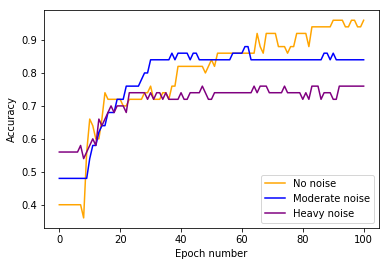

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 

no_noise_accuracies = train_one_model(lr=0.01, n_epochs=100, noise_std_dev=0.0)
noisy_accuracies = train_one_model(lr=0.01, n_epochs=100, noise_std_dev=0.3)
heavy_noise_accuracies = train_one_model(lr=0.01, n_epochs=100, noise_std_dev=1.0)

plt.figure()
plt.plot(no_noise_accuracies, color='orange', label="No noise")
plt.plot(noisy_accuracies, color='blue', label="Moderate noise")
plt.plot(heavy_noise_accuracies, color='purple', label="Heavy noise")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()
